In [1]:
import json
import os

from bs4 import BeautifulSoup
import pandas as pd
import psycopg2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms

In [2]:
connection = psycopg2.connect(host="localhost", dbname="postgres", user="postgres", port=5432)

In [3]:
commit_pct = pd.read_sql("SELECT DISTINCT user_id, package_id, commit_pct FROM open_source.issue_contributors", connection)

In [204]:
language = pd.read_sql("SELECT id as package_id, language FROM open_source.packages", connection)

In [4]:
query = """
SELECT COUNT(*) as total_user_issues, package_id, user_id
FROM open_source.issue_contributors
GROUP BY package_id, user_id
"""

In [5]:
total_user_issues = pd.read_sql(query, connection)

In [6]:
query = """
SELECT COUNT(*) as total_user_comments, package, organization, user_id
FROM open_source.issue_comments
GROUP BY package, organization, user_id
"""

In [7]:
total_user_comments = pd.read_sql(query, connection)

In [8]:
query = """
    SELECT id as package_id, package_name as package, org_name as organization
    FROM open_source.packages
"""

In [9]:
packages = pd.read_sql(query, connection)
package_lookup = dict()
for i in packages.index:
    package_lookup[packages.loc[i]['package_id']] = (packages.loc[i]['package'], packages.loc[i]['organization'])

In [10]:
with open("/home/matt/data/tagtog_requirement_quality/requirement_quality/annotations-legend.json", "r") as f:
    annotations_legend = json.load(f)

In [11]:
HTML_DIR = "/home/matt/data/tagtog_requirement_quality/requirement_quality/plain.html/pool"
filenames = os.listdir(HTML_DIR)

filename_lookup = dict()
for filename in filenames:
    with open(os.path.join(HTML_DIR, filename)) as f:
        html = BeautifulSoup(f).find("html")
        if html:
            filename_lookup[html['id']] = html['data-origid']

In [210]:
ANNO_DIR = "/home/matt/data/tagtog_requirement_quality/requirement_quality/ann.json/master/pool"
filenames = os.listdir(ANNO_DIR)

data = {"issue_id": [], "user_id": [], "package_id":[], "package": [], "organization": []}
for value in annotations_legend.values():
    data[value] = []

for filename in filenames:
    try:
        orig_filename = filename_lookup[filename.replace(".ann.json", "")]
    except KeyError:
        continue
    
    with open(os.path.join(ANNO_DIR, filename), "r") as f:
        labels = json.load(f)
        
    for key, value in annotations_legend.items():
        data[value].append(labels['metas'].get(key, {"value": False})["value"])
    
    
    package_id, user_id, issue_id = tuple(orig_filename.split("-"))
    package, organization = package_lookup[package_id]

    data["package_id"].append(package_id)
    data["issue_id"].append(issue_id)
    data["user_id"].append(user_id)
    data["package"].append(package)
    data["organization"].append(organization)
    
data = pd.DataFrame(data)

In [211]:
github_data = pd.read_csv("../github_data.csv")
similarity_data = pd.read_csv("../similarity_data.csv")
reqs_data = pd.read_csv("../requirement_quality.csv")

reqs_data["user_id"] = reqs_data["user_id"].astype(str)
reqs_data["issue_id"] = reqs_data["issue_id"].astype(str)

In [212]:
data = data.merge(github_data, how="inner", on=["package", "organization", "package_id"])
data = data.merge(reqs_data, how="inner", on=["package_id", "user_id", "issue_id", "package", "organization"])
data = data.merge(total_user_issues, how="inner", on=["package_id", "user_id"])
data = data.merge(total_user_comments, how="inner", on=["package", "organization", "user_id"])
data = data.merge(similarity_data, how="inner", on=["package_id"])
data = data.merge(commit_pct, how="inner", on=["package_id", "user_id"])
data = data.merge(language, how="inner", on=["package_id"])

In [213]:
data["req_quality"] = 0
for key in annotations_legend.values():
    data[key] = data[key].astype(int)
    data["req_quality"] += data[key]

In [216]:
data['good_issue'] = (data["req_quality"] > 3).astype(int)
data['issue_length'] = data["body"].apply(lambda x: len(x))

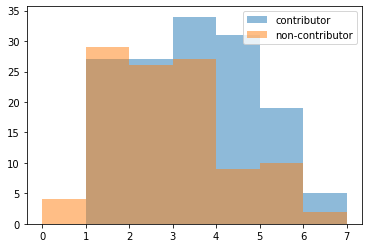

In [217]:
bins = np.linspace(0, 7, 8)

plt.hist(data[data['contributor'] == True]['req_quality'], bins, alpha=0.5, label='contributor')
plt.hist(data[data['contributor'] == False]['req_quality'], bins, alpha=0.5, label='non-contributor')
plt.legend(loc='upper right')
plt.show()

In [218]:
for package_id, count in dict(data['package_id'].value_counts()).items():
    if count > 10:
        data[f"package_{package_id}"] = (data['package_id'] == package_id).astype(int)

In [262]:
data['commit_pct_2'] = data['commit_pct']**2
data['similarity_2'] = data['similarity']**2
data['issue_length_2'] = data['issue_length']**2
data['issue_length_3'] = data['issue_length']**3
data['code_blocks'] = data['body'].apply(lambda x: x.count("`"))
data['num_words'] = data['body'].apply(lambda x: len(x.split()))

In [268]:
formula = """
req_quality ~ contributor + crowd_pct + crowd_pct_2  + similarity +
    issue_length + issue_length_2  + issue_length_3 + code_blocks +
    num_users + topic_2 + topic_6
"""
y, X = dmatrices(formula, data=data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(len(res.params))
print(res.summary())

12
                            OLS Regression Results                            
Dep. Variable:            req_quality   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     18.51
Date:                Sun, 02 Aug 2020   Prob (F-statistic):           1.67e-26
Time:                        18:33:23   Log-Likelihood:                -370.44
No. Observations:                 250   AIC:                             764.9
Df Residuals:                     238   BIC:                             807.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5470 

Text(0, 0.5, 'Count')

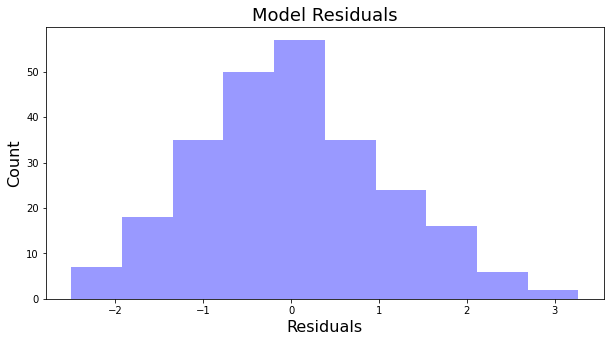

In [236]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=10)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
#plt.xlim([-2.2, 2.2])

In [233]:
formula = """
req_quality ~ contributor + crowd_pct + crowd_pct_2  + similarity  +
    issue_length + issue_length_2  + issue_length_3 + code_blocks +
    num_users + topic_2 + topic_6
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Poisson())
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

0.4444373453191355
12
                 Generalized Linear Model Regression Results                  
Dep. Variable:            req_quality   No. Observations:                  250
Model:                            GLM   Df Residuals:                      238
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -401.43
Date:                Sun, 02 Aug 2020   Deviance:                       112.51
Time:                        18:24:19   Pearson chi2:                     109.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept   